In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from time import time
from sklearn.mixture import GaussianMixture
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.covariance import EmpiricalCovariance, MinCovDet
from sklearn.ensemble import BaggingClassifier, VotingClassifier, IsolationForest
from sklearn.metrics import fbeta_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Prepare for Data
data = pd.read_csv('Project/Statistical_Learning/data/creditcard.csv')
x = np.array(data.loc[1:len(data)-1, 'Time'])
y = np.array(data.loc[0:len(data)-2, 'Time'])
data.loc[1:, 'Time'] = x-y
normal = data[data['Class']==0]
anomaly = data[data['Class']==1]

In [4]:
train_normal, test_normal = train_test_split(normal, test_size=0.4, random_state=42)
valid_normal, test_normal = train_test_split(test_normal, test_size=1/2, random_state=42)
train_anomaly, test_anomaly = train_test_split(anomaly, test_size=0.4, random_state=42)
valid_anomaly, test_anomaly = train_test_split(test_anomaly, test_size=1/2, random_state=42)

for x in [train_normal, valid_normal, test_normal, train_anomaly, valid_anomaly, test_anomaly]:
    x.reset_index(drop=True, inplace=True)

print('Normal Train:', train_normal.shape, 
      'Normal Valid:', valid_normal.shape, 
      'Normal Test:', test_normal.shape)
print('Anomaly Train:', train_anomaly.shape, 
      'Anomaly Valid:', valid_anomaly.shape, 
      'Anomaly Test:', test_anomaly.shape)

Normal Train: (170589, 31) Normal Valid: (56863, 31) Normal Test: (56863, 31)
Anomaly Train: (295, 31) Anomaly Valid: (98, 31) Anomaly Test: (99, 31)


In [5]:
train = train_normal.append(train_anomaly).sample(frac=1, random_state=42).reset_index(drop=True)
valid = valid_normal.append(valid_anomaly).sample(frac=1, random_state=42).reset_index(drop=True)
test = test_normal.append(test_anomaly).sample(frac=1, random_state=42).reset_index(drop=True)

In [6]:
# Print Result
def result(sets, predict):
    
    recall = recall_score(y_true=sets['Class'].values, y_pred=predict)
    precision = precision_score(y_true=sets['Class'].values, y_pred=predict)
    fbeta = fbeta_score(y_true=sets['Class'].values, y_pred=predict, beta=1.5)
    cnf = confusion_matrix(y_true=sets['Class'].values, y_pred=predict)

    print('Recall:', recall, '\nPrecision:', precision, '\nF-score:', fbeta, '\nConfusion Matrix:\n', cnf)

In [7]:
# Print Result for algorithms that need features
def result_all(predictor):
    sets = train
    predict = predictor.predict(feature(gmm, sets).T)
    print('\nTrain:')
    result(sets, predict)
    
    sets = valid
    predict = predictor.predict(feature(gmm, sets).T)
    print('\nValidation:')
    result(sets, predict)
    
    sets = test
    print('\nTest:')
    time_start = time()
    predict = predictor.predict(feature(gmm, sets).T)
    time_end = time()
    result(sets, predict)
        
    return (time_end-time_start)

In [8]:
# GMM Model
class GMM():
    
    def __init__(self, n_normal=3, n_anomaly=4, cov_type='full', random_state=42):
        self.normal = GaussianMixture(n_components=n_normal, covariance_type=cov_type, 
                                      n_init=5, max_iter=500, random_state=random_state, tol=1e-5)
        self.anomaly = GaussianMixture(n_components=n_anomaly, covariance_type=cov_type, 
                                       n_init=5, max_iter=500, random_state=random_state, tol=1e-5)
    
    def fit(self, train_normal, train_anomaly):
        self.normal.fit(train_normal.drop(columns=['Class']))
        self.anomaly.fit(train_anomaly.drop(columns=['Class']))
    
    def predict(self, sets, thre):
        return (thre + self.normal.score_samples(sets.drop(columns=['Class'])) \
                <= self.anomaly.score_samples(sets.drop(columns=['Class']))).astype(np.int32)
    
    def Valid(self, sets, tune, draw=0):
        score = []
        for p in tune:
            pred = self.predict(sets, p)
            recall = recall_score(y_true=sets['Class'].values, y_pred=pred)
            precision = precision_score(y_true=sets['Class'].values, y_pred=pred)
            fbeta = fbeta_score(y_true=sets['Class'].values, y_pred=pred, beta=2)
            score.append([recall, precision, fbeta])
        score = np.array(score)
        self.threshold = tune[score[:, 2].argmax()]
        if draw:
            plt.plot(tune, score[:, 0], label='$Recall$')
            plt.plot(tune, score[:, 1], label='$Precision$')
            plt.plot(tune, score[:, 2], label='$F_2$')
            plt.ylabel('Score')
            plt.xlabel('Threshold')
            plt.legend(loc='best')
            plt.show()
            pred = self.predict(sets, self.threshold)
        
    def Test(self, sets):
        pred = self.predict(sets, self.threshold)
        result(sets, pred)
    

In [9]:
# Extract Feature
def feature(self, sets):
    
    feature_normal = np.array([])

    l = len(self.normal.means_)
    for i in range(l):
        x = np.array(sets.drop(columns=['Class']) - self.normal.means_[i])
        x = np.sum(x.dot(np.linalg.inv(self.normal.covariances_[i])) * x, axis=1)
        feature_normal = np.append(feature_normal, x, axis=0)
    feature_normal = feature_normal.reshape(l, -1)
    feature_anomaly = np.array([])
    
    l = len(self.anomaly.means_)
    for i in range(l):
        x = np.array(sets.drop(columns=['Class']) - self.anomaly.means_[i])
        x = np.sum(x.dot(np.linalg.inv(self.anomaly.covariances_[i])) * x, axis=1)
        feature_anomaly = np.append(feature_anomaly, x, axis=0)
    feature_anomaly = feature_anomaly.reshape(l, -1)
    
    normal_score = self.normal.score_samples(sets.drop(columns=['Class'])).reshape(1, -1)
    anomaly_score = self.anomaly.score_samples(sets.drop(columns=['Class'])).reshape(1, -1)
    
    features = normal_score - anomaly_score
    features = np.concatenate((features, feature_normal, feature_anomaly), axis=0)
    #features = np.concatenate((features, normal_score, anomaly_score), axis=0)
              
    #for i in range(len(feature_normal)):
    #    for j in range(len(feature_anomaly)):
    #        features = np.append(features, np.array([feature_normal[i] - feature_anomaly[j]]), axis=0)
    
    return features

### Data Preprocessing(Visualization)

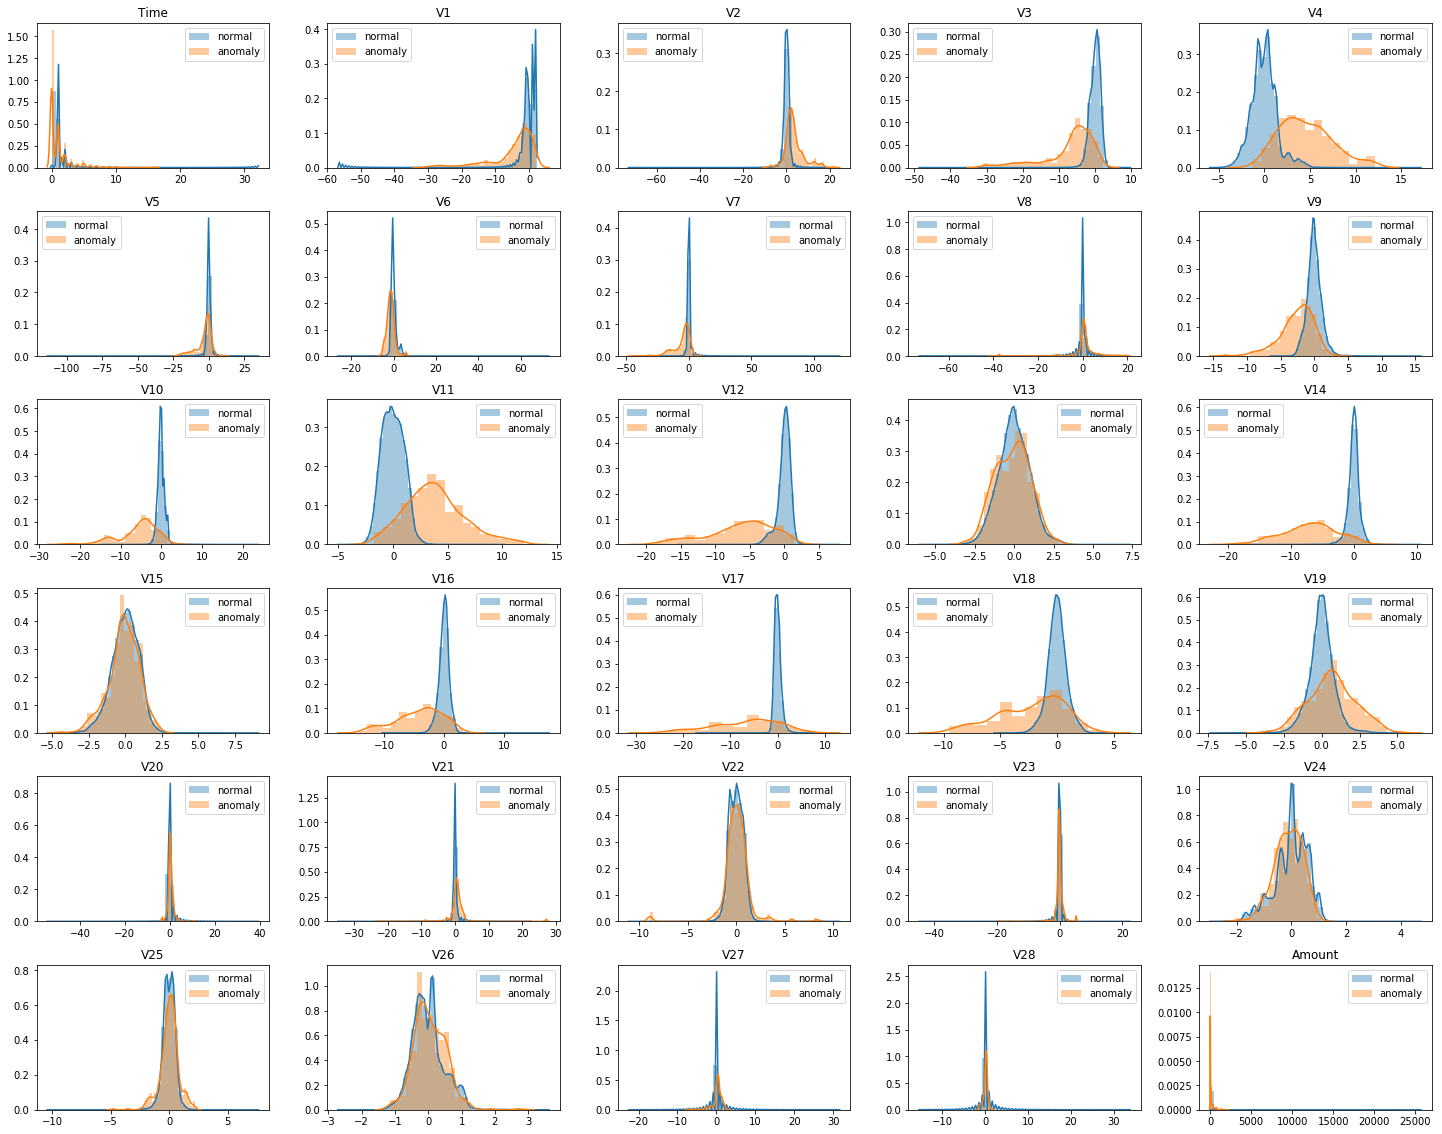

In [10]:
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(25, 20))
plt.subplots_adjust(hspace=0.3, wspace=0.25)
i = 0
for ax in axes.flat:
    sns.distplot(np.array(normal.iloc[:, i]), label='normal', kde=True, norm_hist=False, ax=ax)
    sns.distplot(np.array(anomaly.iloc[:, i]), label='anomaly', kde=True, norm_hist=False, ax=ax)
    ax.set(title=data.columns[i])
    ax.legend()
    i += 1

### GMDA

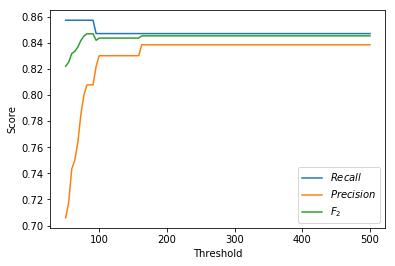

GMDA

Train:
Recall: 0.8 
Precision: 0.8 
F-score: 0.8 
Confusion Matrix:
 [[170530     59]
 [    59    236]]

Validation:
Recall: 0.8571428571428571 
Precision: 0.8076923076923077 
F-score: 0.8412942989214176 
Confusion Matrix:
 [[56843    20]
 [   14    84]]

Test:
Recall: 0.8080808080808081 
Precision: 0.8163265306122449 
F-score: 0.8106001558846452 
Confusion Matrix:
 [[56845    18]
 [   19    80]]


In [11]:
train_start = time()
gmm = GMM(n_anomaly=3)
gmm.fit(train_normal, train_anomaly)
train_end = time()
gmm.Valid(valid, np.linspace(50, 500, 101), draw=1)
print('GMDA')
print('\nTrain:')
gmm.Test(train)
print('\nValidation:')
gmm.Test(valid)
print('\nTest:')
test_start = time()
gmm.Test(test)
test_end = time()

### GMDA with normal data only

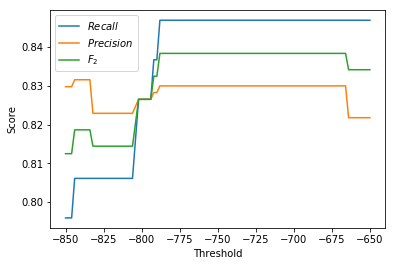

GMDA-n

Train:
Recall: 0.7762711864406779 
Precision: 0.8207885304659498 
F-score: 0.7894457703526915 
Confusion Matrix:
 [[170539     50]
 [    66    229]]

Validation:
Recall: 0.8469387755102041 
Precision: 0.83 
F-score: 0.8416536661466458 
Confusion Matrix:
 [[56846    17]
 [   15    83]]

Test
Recall: 0.797979797979798 
Precision: 0.8494623655913979 
F-score: 0.8131433095803642 
Confusion Matrix:
 [[56849    14]
 [   20    79]]


In [12]:
x = valid

tune = np.linspace(-850, -650, 101)
score = []
for p in tune:
    predict_gmm = (gmm.normal.score_samples(x.drop(columns=['Class'])) <= p).astype(np.int32)
    predict = predict_gmm
    recall_gmm = recall_score(y_true=x['Class'].values, y_pred=predict)
    precision_gmm = precision_score(y_true=x['Class'].values, y_pred=predict)
    fbeta_gmm = fbeta_score(y_true=x['Class'].values, y_pred=predict, beta=1)
    score.append([recall_gmm, precision_gmm, fbeta_gmm])
score = np.array(score)
plt.plot(tune, score[:, 0], label='$Recall$')
plt.plot(tune, score[:, 1], label='$Precision$')
plt.plot(tune, score[:, 2], label='$F_2$')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()
p = tune[score[:, 2].argmax()]
print('GMDA-n')
print('\nTrain:')
predict = (gmm.normal.score_samples(train.drop(columns=['Class'])) <= p).astype(np.int32)
result(train, predict)
print('\nValidation:')
predict = (gmm.normal.score_samples(valid.drop(columns=['Class'])) <= p).astype(np.int32)
result(valid, predict)
print('\nTest')
test_start = time()
predict = (gmm.normal.score_samples(test.drop(columns=['Class'])) <= p).astype(np.int32)
result(test, predict)
test_end = time()

### GMDA with Decision Tree Classifer

In [13]:
print('GMDA-dtc')
train_start = time()
dtc = DecisionTreeClassifier(criterion='entropy', max_depth=5).fit(feature(gmm, train).T, train['Class'])
train_end = time()
test_time = result_all(dtc)

GMDA-dtc

Train:
Recall: 0.8271186440677966 
Precision: 0.9242424242424242 
F-score: 0.8547561304230665 
Confusion Matrix:
 [[170569     20]
 [    51    244]]

Validation:
Recall: 0.8367346938775511 
Precision: 0.8541666666666666 
F-score: 0.8420221169036335 
Confusion Matrix:
 [[56849    14]
 [   16    82]]

Test:
Recall: 0.7878787878787878 
Precision: 0.896551724137931 
F-score: 0.818401937046005 
Confusion Matrix:
 [[56854     9]
 [   21    78]]


### GMDA with Bagging

In [14]:
bgc = BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=5), 
                        bootstrap_features=False, n_estimators=11)

print('GM-bag')
train_start = time()
bgc.fit(feature(gmm, train).T, train['Class'])
train_end = time()
test_time = result_all(bgc)

GM-bag

Train:
Recall: 0.8067796610169492 
Precision: 0.9635627530364372 
F-score: 0.849300027449904 
Confusion Matrix:
 [[170580      9]
 [    57    238]]

Validation:
Recall: 0.8469387755102041 
Precision: 0.8924731182795699 
F-score: 0.8604465709728867 
Confusion Matrix:
 [[56853    10]
 [   15    83]]

Test:
Recall: 0.7878787878787878 
Precision: 0.9176470588235294 
F-score: 0.8237205523964256 
Confusion Matrix:
 [[56856     7]
 [   21    78]]


### GMDA with Voting

In [15]:
estimators = [
              ('dtc1',DecisionTreeClassifier(criterion='entropy', max_depth=5, class_weight={0:1, 1:0.01})),
              ('dtc2',DecisionTreeClassifier(criterion='entropy', max_depth=5, class_weight={0:1, 1:0.02})),
              ('dtc3',DecisionTreeClassifier(criterion='entropy', max_depth=5, class_weight={0:1, 1:0.05})),
              ('dtc4',DecisionTreeClassifier(criterion='entropy', max_depth=5, class_weight={0:1, 1:0.1})),
              ('dtc5',DecisionTreeClassifier(criterion='entropy', max_depth=5, class_weight={0:1, 1:1})),
              ('dtc6',DecisionTreeClassifier(criterion='entropy', max_depth=5, class_weight={0:1, 1:10})),
              ('dtc7',DecisionTreeClassifier(criterion='entropy', max_depth=5, class_weight={0:1, 1:20})), 
              ('dtc8',DecisionTreeClassifier(criterion='entropy', max_depth=5, class_weight={0:1, 1:50})), 
              ('dtc9',DecisionTreeClassifier(criterion='entropy', max_depth=5, class_weight={0:1, 1:100})),
             ]
vtc = VotingClassifier(estimators=estimators, voting='soft')#, weights=[1, 1.1, 1.1, 1.1, 1.1, 1])

print('GM-voting')
train_start = time()
vtc.fit(feature(gmm, train).T, train['Class'])
train_end = time()
test_time = result_all(bgc)

GM-voting

Train:
Recall: 0.8067796610169492 
Precision: 0.9635627530364372 
F-score: 0.849300027449904 
Confusion Matrix:
 [[170580      9]
 [    57    238]]

Validation:
Recall: 0.8469387755102041 
Precision: 0.8924731182795699 
F-score: 0.8604465709728867 
Confusion Matrix:
 [[56853    10]
 [   15    83]]

Test:
Recall: 0.7878787878787878 
Precision: 0.9176470588235294 
F-score: 0.8237205523964256 
Confusion Matrix:
 [[56856     7]
 [   21    78]]


### GMDA with XGBoost

In [16]:
print('GM-xgb')
train_start = time()
xg = xgb.XGBClassifier(max_depth=5, reg_alpha=0.2).fit(feature(gmm, train).T, train['Class'])
train_end = time()
test_time = result_all(xg)

GM-xgb

Train:
Recall: 0.8677966101694915 
Precision: 0.9884169884169884 
F-score: 0.9016526686534815 
Confusion Matrix:
 [[170586      3]
 [    39    256]]

Validation:
Recall: 0.8469387755102041 
Precision: 0.9120879120879121 
F-score: 0.8659711075441413 
Confusion Matrix:
 [[56855     8]
 [   15    83]]

Test:
Recall: 0.8080808080808081 
Precision: 0.9411764705882353 
F-score: 0.8448415922014622 
Confusion Matrix:
 [[56858     5]
 [   19    80]]


### Robust Covariance Estimation

In [17]:
train_start = time()
robust_cov = MinCovDet().fit(train)
train_end = time()
p = 10**6+4*10**4
print('RCE')
predict = (robust_cov.mahalanobis(train) > p).astype(np.int32)
print('\nTrain:')
result(train, predict)
predict = (robust_cov.mahalanobis(valid) > p).astype(np.int32)
print('\nValidation:')
result(valid, predict)
test_start = time()
predict = (robust_cov.mahalanobis(test) > p).astype(np.int32)
print('\nTest:')
result(test, predict)
test_end = time()

RCE

Train:
Recall: 0.7220338983050848 
Precision: 0.040030069535801543 
F-score: 0.1156689920213877 
Confusion Matrix:
 [[165481   5108]
 [    82    213]]

Validation:
Recall: 0.7959183673469388 
Precision: 0.04645622394282311 
F-score: 0.13345617267702026 
Confusion Matrix:
 [[55262  1601]
 [   20    78]]

Test:
Recall: 0.797979797979798 
Precision: 0.04440697020798201 
F-score: 0.12826277007618334 
Confusion Matrix:
 [[55163  1700]
 [   20    79]]


### Isolation Forest

In [18]:
time_start = time()
ilf = IsolationForest(n_estimators=250, contamination=0.005, bootstrap=False, 
                      behaviour='new').fit(train_normal.drop(columns=['Class']))
time_end = time()

print('ILF')
x = train
predict = (1-ilf.predict(x.drop(columns=['Class'])))/2
print('\nTrain:')
result(train, predict)
x = valid
predict = (1-ilf.predict(x.drop(columns=['Class'])))/2
print('\nValidation:')
result(valid, predict)
x = test
test_start = time()
predict = (1-ilf.predict(x.drop(columns=['Class'])))/2
print('\nTest:')
result(test, predict)
test_end = time()

ILF

Train:
Recall: 0.43389830508474575 
Precision: 0.13114754098360656 
F-score: 0.25369720994053974 
Confusion Matrix:
 [[169741    848]
 [   167    128]]

Validation:
Recall: 0.40816326530612246 
Precision: 0.12084592145015106 
F-score: 0.2357207615593835 
Confusion Matrix:
 [[56572   291]
 [   58    40]]

Test:
Recall: 0.4444444444444444 
Precision: 0.1301775147928994 
F-score: 0.2550156041016496 
Confusion Matrix:
 [[56569   294]
 [   55    44]]


### Local Outlier Factor

In [19]:
train_start = time()
lof = LocalOutlierFactor(n_neighbors=50, novelty=True, contamination=0.0008).fit(train_normal.drop(columns=['Class']))
train_end = time()

print('LOF')
x = train
predict = (1-lof.predict(x.drop(columns=['Class'])))/2
print('\nTrain:')
result(train, predict)
x = valid
predict = (1-lof.predict(x.drop(columns=['Class'])))/2
print('\nValidation:')
result(valid, predict)
x = test
test_start = time()
predict = (1-lof.predict(x.drop(columns=['Class'])))/2
print('\nTest:')
result(test, predict)
test_end = time()

LOF

Train:
Recall: 0.5084745762711864 
Precision: 0.5454545454545454 
F-score: 0.5193075898801597 
Confusion Matrix:
 [[170464    125]
 [   145    150]]

Validation:
Recall: 0.5510204081632653 
Precision: 0.5346534653465347 
F-score: 0.5458786936236392 
Confusion Matrix:
 [[56816    47]
 [   44    54]]

Test:
Recall: 0.5050505050505051 
Precision: 0.5154639175257731 
F-score: 0.508209538702111 
Confusion Matrix:
 [[56816    47]
 [   49    50]]
